In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [15]:
folder_path = r"C:\Users\bensi\Documents\20250925"
csv_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')]
os.chdir(r"C:\Users\bensi\Dropbox\Thesis figures")
dataframes = {}
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, skiprows=8, header=None, names=["frequency", "Amplitude", "Phase"])
    # Use file name without extension as the key
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = df

In [ ]:
1beam_cic

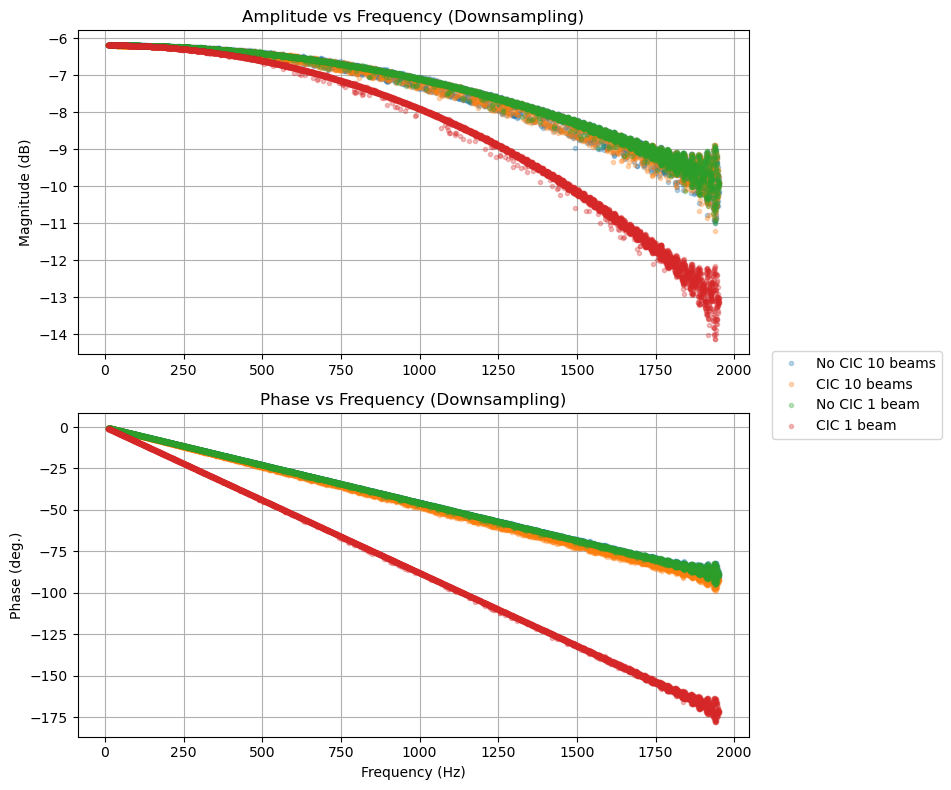

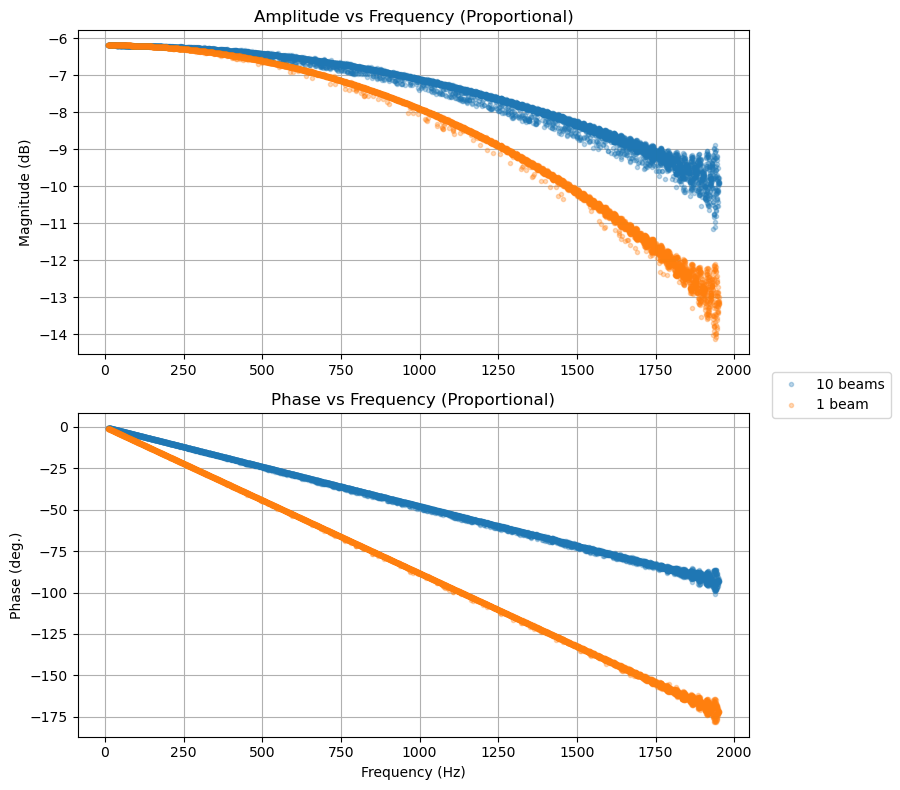

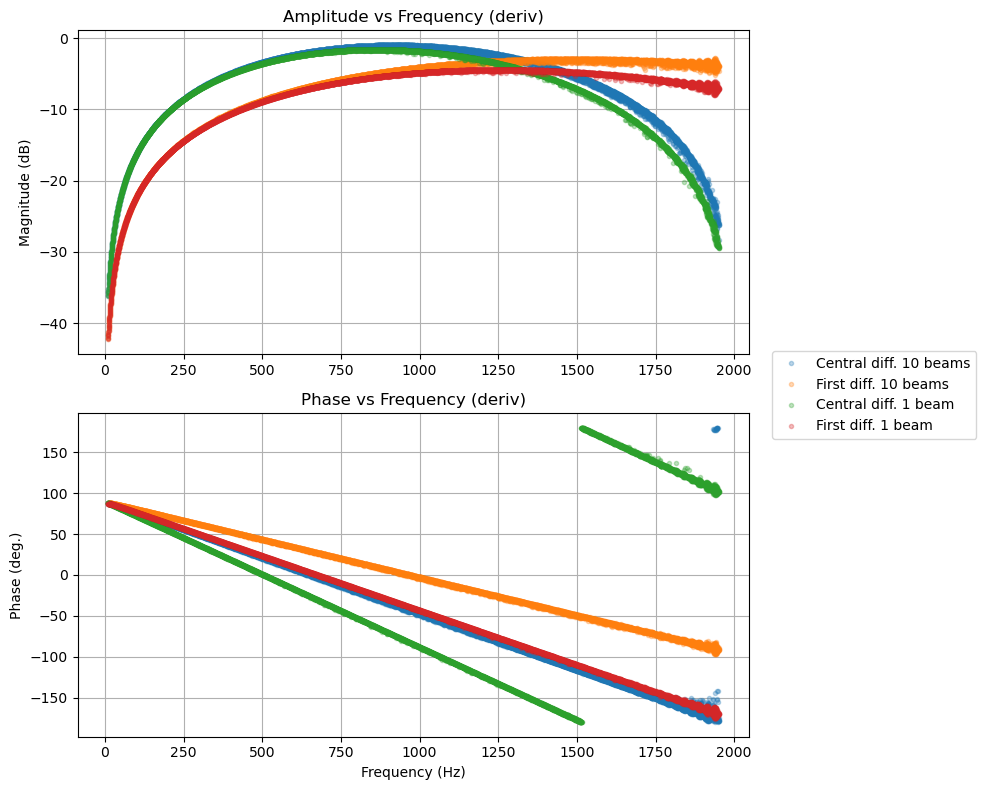

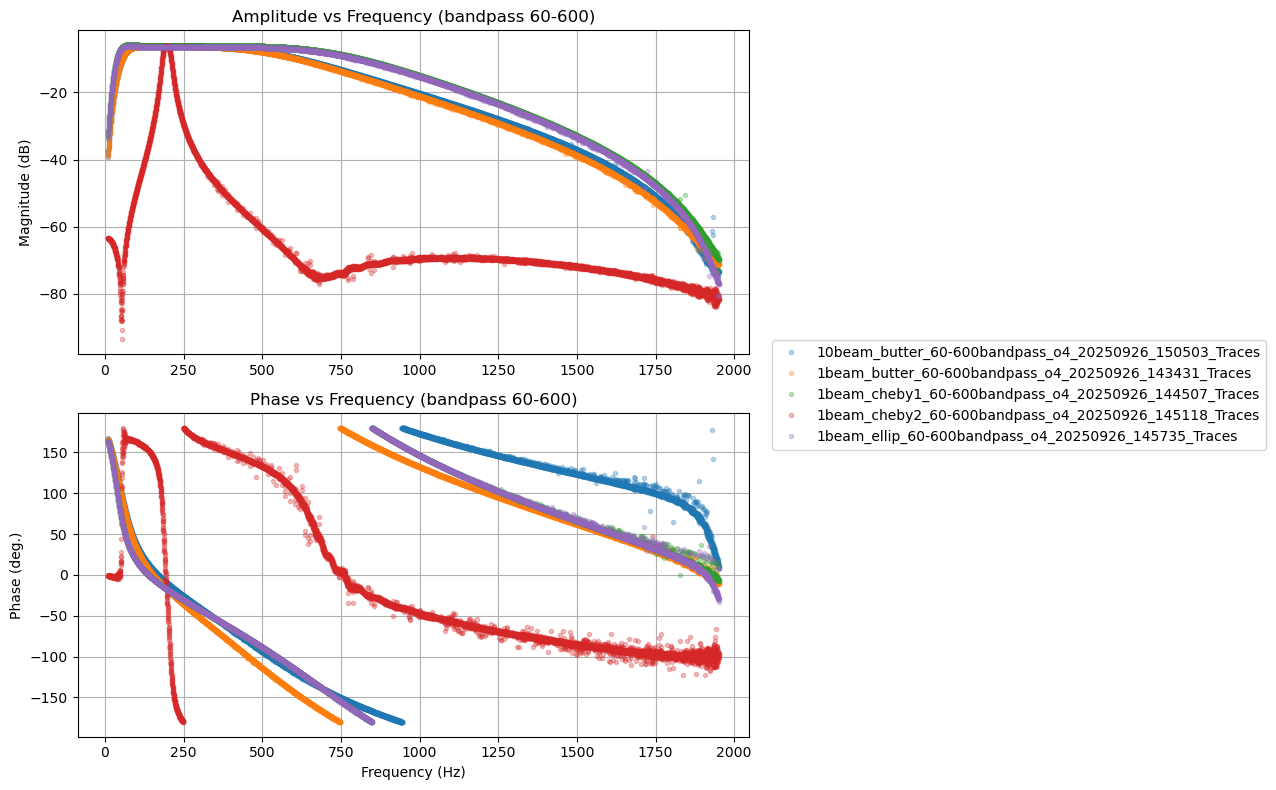

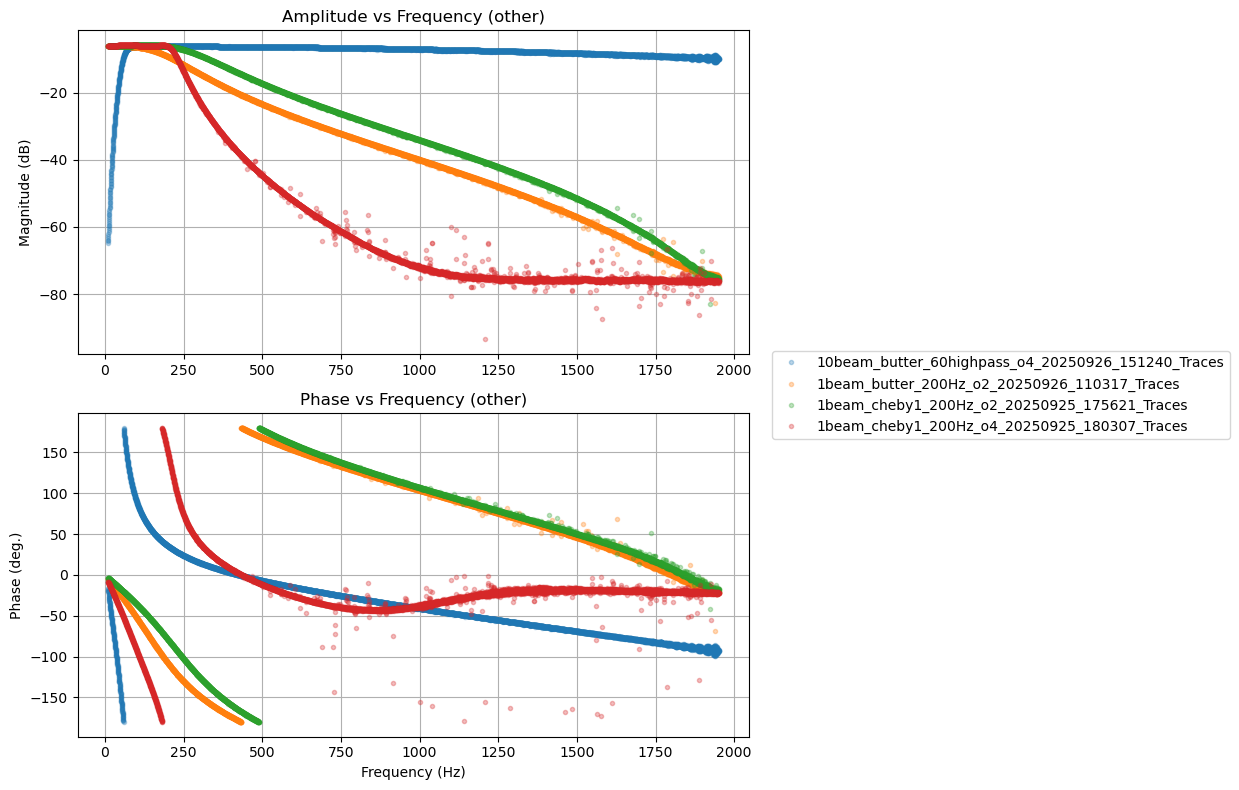

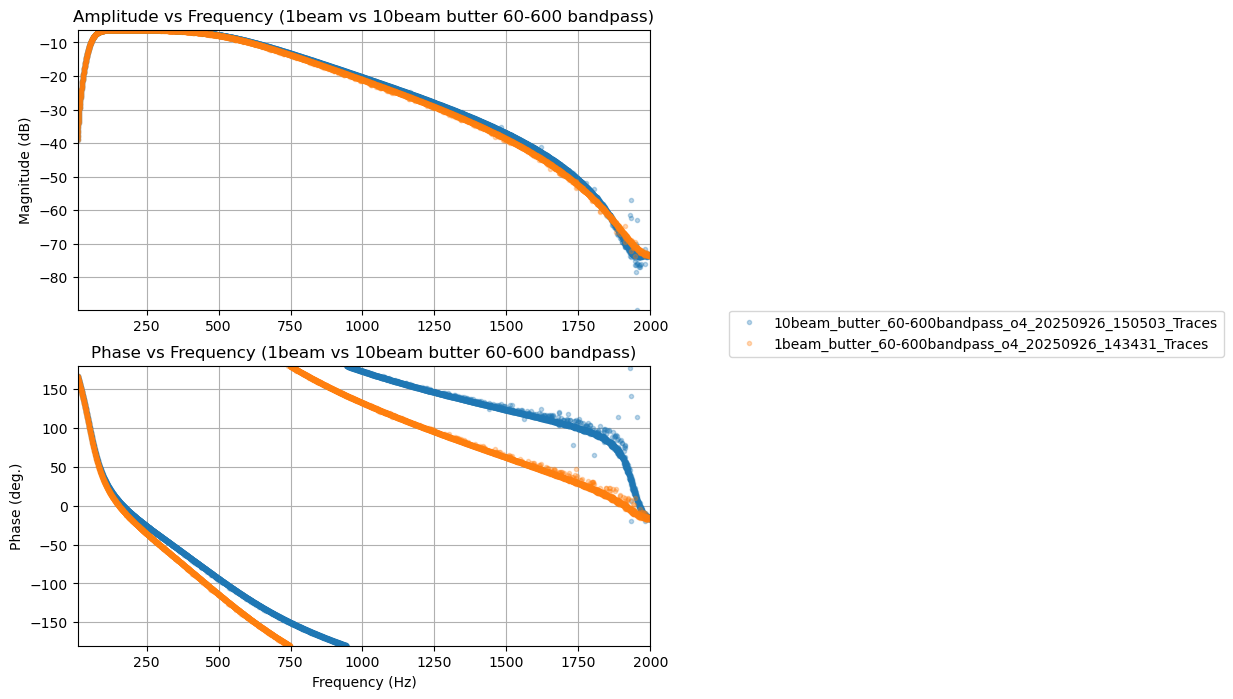

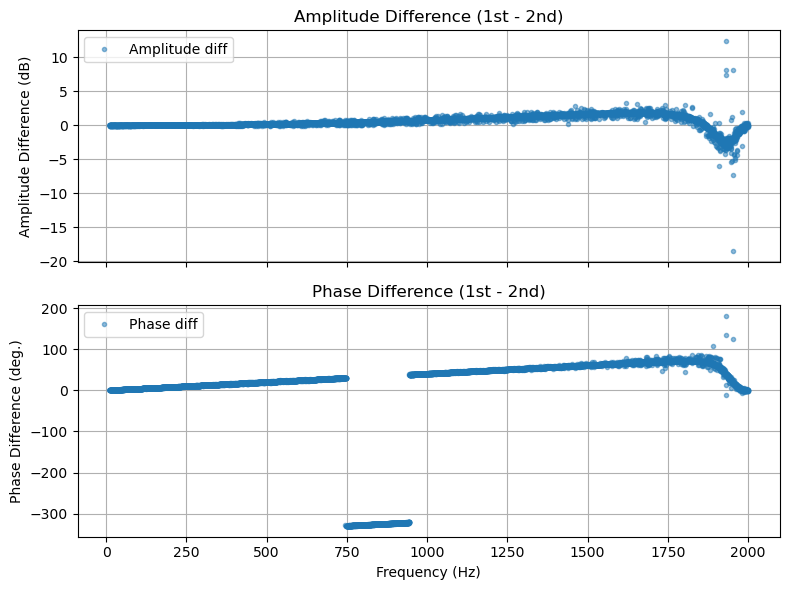

In [17]:


# Helper function to plot dataframes on a bode plot
def plot_bode(selected_dfs, title_suffix, legend=None):
    fig = plt.figure(figsize=(10, 8))
    # Use gridspec to allocate only the left 3/4 for the plots
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[1, :3], sharex=ax1)

    for name, df in selected_dfs.items():
        ax1.plot(df["frequency"][:-200], df["Amplitude"][:-200], '.', label=name, alpha=0.3)
    ax1.set_ylabel("Magnitude (dB)")
    ax1.set_title(f"Amplitude vs Frequency {title_suffix}")
    ax1.grid(True)
    #ax1.set_xlim(0, 2000)
    #ax1.set_ylim(-20, 0)  # Set y limits from -20 to 0

    for name, df in selected_dfs.items():
        ax2.plot(df["frequency"][:-200], df["Phase"][:-200], '.', label=name, alpha=0.3)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Phase (deg.)")
    ax2.set_title(f"Phase vs Frequency {title_suffix}")
    ax2.grid(True)
    #ax2.set_xlim(0, 2000)

    handles, labels = ax1.get_legend_handles_labels()
    # Place legend in the right 1/4 of the figure
    if legend == None:
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.77, 0.5))
    else:
        fig.legend(legend, loc='center left', bbox_to_anchor=(0.77, 0.5))
    plt.tight_layout()
    plt.show()
    return fig

# Split dataframes by name
pass_dfs = {name: df for name, df in dataframes.items() if (("pass" in name.lower()) and not any(x in name.lower() for x in ["butter", "cheby", "ellip"]))}
prop_dfs = {name: df for name, df in dataframes.items() if (("prop" in name.lower()) and not any(x in name.lower() for x in ["butter", "cheby", "ellip"]))}
deriv_dfs = {name: df for name, df in dataframes.items() if ("deriv" in name.lower() and not any(x in name.lower() for x in ["butter", "cheby", "ellip"]))}
bandpass_dfs = {name: df for name, df in dataframes.items() if ("60-600bandpass" in name.lower())}
other_dfs = {name: df for name, df in dataframes.items() if name not in pass_dfs and name not in prop_dfs and name not in deriv_dfs and name not in bandpass_dfs}


CIC_1 = {name: df for name, df in dataframes.items() if name.startswith("1beam_pass")}
CIC_10 = {name: df for name, df in dataframes.items() if name.startswith("10beam_pass")}


#correct for response of CIC decimators
def cic_response_subtraction(df, beamnum, CIC_1, CIC_10):
    df["Amplitude"] = df["Amplitude"] - CIC_1["Amplitude"] if beamnum == 1 else df["Amplitude"] - CIC_10["Amplitude"]
    df["Phase"] = df["Phase"] - CIC_1["Phase"] if beamnum == 1 else df["Phase"] - CIC_10["Phase"]

    return df


# Plot each group
pass_fig = plot_bode(pass_dfs, "(Downsampling)", legend=["No CIC 10 beams", "CIC 10 beams", "No CIC 1 beam", "CIC 1 beam"])
pass_fig.savefig("FPGA_response_downsampling.png", dpi=300)
prop_fig = plot_bode(prop_dfs, "(Proportional)", legend=["10 beams", "1 beam"])
prop_fig.savefig("FPGA_response_proportional.png", dpi=300)
deriv_fig = plot_bode(deriv_dfs, "(deriv)", legend=["Central diff. 10 beams", "First diff. 10 beams", "Central diff. 1 beam", "First diff. 1 beam"])
deriv_fig.savefig("FPGA_response_derivative.png", dpi=300)
band_fig = plot_bode(bandpass_dfs, "(bandpass 60-600)")
other_fig = plot_bode(other_dfs, "(other)")

# Compare specific butter bandpass dataframes
compare_butter_dfs = {name: df for name, df in dataframes.items()
                      if name.startswith("1beam_butter_60-600bandpass") or name.startswith("10beam_butter_60-600bandpass")}

def plot_bode_autoscale(selected_dfs, title_suffix):
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[1, :3], sharex=ax1)

    # Plot amplitude
    for name, df in selected_dfs.items():
        ax1.plot(df["frequency"], df["Amplitude"], '.', label=name, alpha=0.3)
    ax1.set_ylabel("Magnitude (dB)")
    ax1.set_title(f"Amplitude vs Frequency {title_suffix}")
    ax1.grid(True)
    ax1.autoscale(enable=True, axis='both', tight=True)

    # Plot phase
    for name, df in selected_dfs.items():
        ax2.plot(df["frequency"], df["Phase"], '.', label=name, alpha=0.3)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Phase (deg.)")
    ax2.set_title(f"Phase vs Frequency {title_suffix}")
    ax2.grid(True)
    ax2.autoscale(enable=True, axis='both', tight=True)

    # Plot difference (assumes exactly two dataframes) in a separate figure
    if len(selected_dfs) == 2:
        names = list(selected_dfs.keys())
        df1 = selected_dfs[names[0]]
        df2 = selected_dfs[names[1]]
        freq_common = df1["frequency"]
        amp1 = df1["Amplitude"]
        amp2 = df2["Amplitude"]
        phase1 = df1["Phase"]
        phase2 = df2["Phase"]

        fig_diff, (ax_amp_diff, ax_phase_diff) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
        ax_amp_diff.plot(freq_common, amp1 - amp2, '.', label="Amplitude diff", alpha=0.5)
        ax_amp_diff.set_ylabel("Amplitude Difference (dB)")
        ax_amp_diff.set_title("Amplitude Difference (1st - 2nd)")
        ax_amp_diff.grid(True)
        ax_amp_diff.legend()

        ax_phase_diff.plot(freq_common, phase1 - phase2, '.', label="Phase diff", alpha=0.5)
        ax_phase_diff.set_xlabel("Frequency (Hz)")
        ax_phase_diff.set_ylabel("Phase Difference (deg.)")
        ax_phase_diff.set_title("Phase Difference (1st - 2nd)")
        ax_phase_diff.grid(True)
        ax_phase_diff.legend()

        plt.tight_layout()

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.77, 0.5))
    plt.tight_layout()
    plt.show()


plot_bode_autoscale(compare_butter_dfs, "(1beam vs 10beam butter 60-600 bandpass)")
